In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = {}
for year in range(1997,2018):
    df[year] = pd.read_csv('data/cleaned/msa_naicssector_cleaned_totEmploy_'+str(year)+'.csv')
    df[year]['Total Employment'] = pd.to_numeric( df[year]['Total Employment'],downcast='integer',errors='coerce' )
    df[year] = df[year].dropna()
    df[year].rename(columns= {'Total Employment':'Total Employment - '+str(year)} ,inplace=True)
    
    del df[year]['FIPS Code'], df[year]['NAICS Description']#, df[year]['Unnamed: 0']
    

In [4]:
unique_NAICS_codes = set( df[1998]['NAICS Code'].unique() )
for year in range(1999,2018):
    unique_NAICS_codes = unique_NAICS_codes & set( df[year]['NAICS Code'].unique() )
    
    
MSA_df = pd.read_csv('data/MSA_wikipedia.csv',delimiter='\t')

MSAs = MSA_df['Metropolitan statistical area ']
MSA_shorts = MSAs.map(lambda x: x.split(',')[0].split('-')[0].lower() )
MSA_shorts_dict = {MSA_shorts.iloc[i]:
                   {'MSA': MSAs.iloc[i][:-1],
                    'State': MSAs.iloc[i].split(', ')[1].split(' ')[0] } for i in range(len(MSAs))  }


state_abbr_df = pd.read_csv('data/state_abbr.csv',delimiter='\t',names=['State','Abbr.'])
state_to_abbr_dict = { state_abbr_df['State'].iloc[i].title()[0:-1] :state_abbr_df['Abbr.'].iloc[i] for i in range(len(state_abbr_df)) }
state_to_abbr_dict['United States'] = 'US'

abbr_to_state_dict ={ v:k for k,v in state_to_abbr_dict.items()}

MSA_to_state_dict = { MSAs.iloc[i][:-1]: MSAs.iloc[i].split(', ')[1].split(' ')[0]  for i in range(len(MSAs))  }

In [5]:
# for 1997-2002
def standard_MSA_v1(string):
    for short in MSA_shorts_dict.keys():
        if (short in string.lower()) and string.split(', ')[1].split(' ')[0]==MSA_shorts_dict[short]['State']:
            return MSA_shorts_dict[short]
    return { 'MSA':None, 'State':None }
# for 2003-2017
def standard_MSA_v2(string):
    if 'micro' in string.lower():
        return { 'MSA':None, 'State':None }
    for short in MSA_shorts_dict.keys():
        if (short in string.lower()) and string.split(', ')[1].split(' ')[0]==MSA_shorts_dict[short]['State']:
            return MSA_shorts_dict[short]
    return { 'MSA':None, 'State':None }

for year in range(1998,2003):
    df[year]['MSA'] = df[year]['MSA Description'].map( lambda x: standard_MSA_v1(x)['MSA'] )
    #df[year]['State'] = df[year]['MSA Description'].map( lambda x: standard_MSA_v1(x)[1] )
    df[year] = df[year][ ~df[year]['MSA'].isna() ] 
    del df[year]['MSA Description']
        
for year in range(2003,2018):
    df[year]['MSA'] = df[year]['MSA Description'].map( lambda x: standard_MSA_v2(x)['MSA'] )
    #df[year]['State'] = df[year]['MSA Description'].map( lambda x: standard_MSA_v2(x)[1] )
    df[year] = df[year][ ~df[year]['MSA'].isna() ] 
    del df[year]['MSA Description']
    

In [6]:
# save data
for year in range(1998,2018):
    df[year].to_csv('data/cleaned/msa_naicssector_cleanedv2_totEmploy_'+str(year)+'.csv',index=False)

In [142]:
df1 = {}
year_start = 1998
for year in range(year_start,2018):
    df1[year] = df[year].set_index(['MSA','NAICS Code'],drop=True)

In [143]:
df_all = df1[year_start]
for year in range(year_start+1,2018):
    df_all = pd.merge(df_all, df1[year],how='inner' ,on=['MSA','NAICS Code'],copy=False )
    df_all.to_csv('data/draft/df_all_merge_'+str(year)+'.csv')

In [191]:
df_all_ppc=df_all[[]].copy()
for year in range(year_start,2017):
    df_all_ppc['TotEmp - P.P.C. - '+str(year)+'-'+str(year+1)] = \
    100*(df_all['Total Employment - '+str(year+1)]- df_all['Total Employment - '+str(year)])/df_all['Total Employment - '+str(year)]
    
df_all_ppc = df_all_ppc.T
df_all_ppc.index = list(range(year_start+1,2018))

In [12]:
# Load the state data
df_state = {}
for year in range(1998,2018):
    df_state[year] = pd.read_csv('data/cleaned/state_naicssector_cleaned_totEmploy_'+str(year)+'.csv')
    del df_state[year]['NAICS Description']
    df_state[year]['Total Employment'] = pd.to_numeric( df_state[year]['Total Employment'],downcast='integer',errors='coerce' )
    df_state[year] = df_state[year].dropna()
    #df_state[year].set_index(['State','NAICS Code'],drop=True,inplace=True)
    df_state[year].rename(columns= {'Total Employment':'Total Employment - '+str(year)} ,inplace=True)
    #df_state[year].rename(columns= {'Total Employment':'Total Employment - '+str(year)} ,inplace=True)

In [13]:
for year in range(1998,2018):
    df_state[year].to_csv('data/cleaned/state_naicssector_cleanedv2_totEmploy_'+str(year)+'.csv',index=False)

In [182]:
df_state_all = df_state[year_start]
for year in range(year_start+1,2018):
    df_state_all = pd.merge(df_state_all, df_state[year],how='inner' ,on=['State','NAICS Code'],copy=False )
    #print(year, len(df_state_all) )

In [192]:
df_state_all_ppc=df_state_all[[]].copy()
for year in range(year_start,2017):
    df_state_all_ppc['TotEmp - P.P.C. - '+str(year)+'-'+str(year+1)] =   100*(df_state_all['Total Employment - '+str(year+1)]-
                                                                          df_state_all['Total Employment - '+str(year)])/\
                                                                            df_state_all['Total Employment - '+str(year)]
    
df_state_all_ppc = df_state_all_ppc.T
df_state_all_ppc.index = list(range(year_start+1,2018))

In [193]:
def ppc_relative( MSA,NAICS_code ):
    return (df_all_ppc[ (MSA,NAICS_code) ]-df_state_all_ppc[ ( abbr_to_state_dict[MSA_to_state_dict[MSA]] ,NAICS_code) ],
            df_all_ppc[ (MSA,NAICS_code) ]-df_state_all_ppc[ ( 'United States' ,NAICS_code) ] )

In [233]:
#MSA = 'Los Angeles-Long Beach-Anaheim, CA MSA'
#MSA = 'Riverside-San Bernardino-Ontario, CA MSA'
MSA = 'San Diego-Chula Vista-Carlsbad, CA MSA'
#MSA = 'Oxnard-Thousand Oaks-Ventura, CA MSA'
#MSA = 'Santa Maria-Santa Barbara, CA MSA'

#MSA = 'Denver-Aurora-Lakewood, CO MSA'
NAICS_code = '--'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
#df_all_ppc[ (MSA,NAICS_code) ]
#abbr_to_state_dict[MSA_to_state_dict[MSA]]
#ppc_relative_state, ppc_relative_country

Text(0, 0.5, 'Percentage Point Change, Relative the Californai')

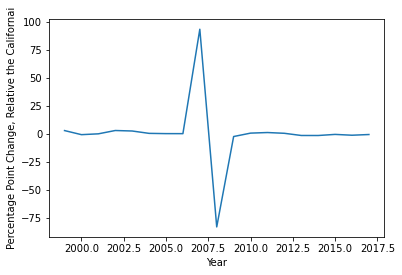

In [234]:
plt.figure()
#plt.plot( relative_state.index,ppc  )
plt.plot( list(range(year_start+1,2018)),ppc_relative_state  )
#plt.plot( relative_state.index,ppc_relative_country  )
plt.xlabel('Year')
plt.ylabel('Percentage Point Change, Relative the Californai')

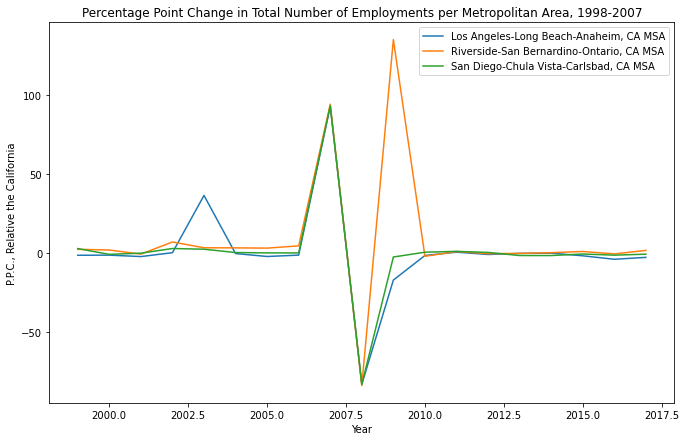

In [254]:
plt.figure()

fsize = 7
plt.gcf().set_size_inches(fsize*1.6,fsize)

MSA = 'Los Angeles-Long Beach-Anaheim, CA MSA'
NAICS_code = '--'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
plt.plot( list(range(year_start+1,2018)),ppc_relative_state ,label= MSA)


MSA = 'Riverside-San Bernardino-Ontario, CA MSA'
NAICS_code = '--'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
plt.plot( list(range(year_start+1,2018)),ppc_relative_state ,label= MSA)

MSA = 'San Diego-Chula Vista-Carlsbad, CA MSA'
NAICS_code = '--'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
plt.plot( list(range(year_start+1,2018)),ppc_relative_state ,label= MSA)

plt.xlabel('Year')
plt.ylabel('P.P.C., Relative the California')
plt.title('Percentage Point Change in Total Number of Employments per Metropolitan Area, 1998-2007')
plt.legend()
plt.savefig('data/ppc_totEmp_total.png')

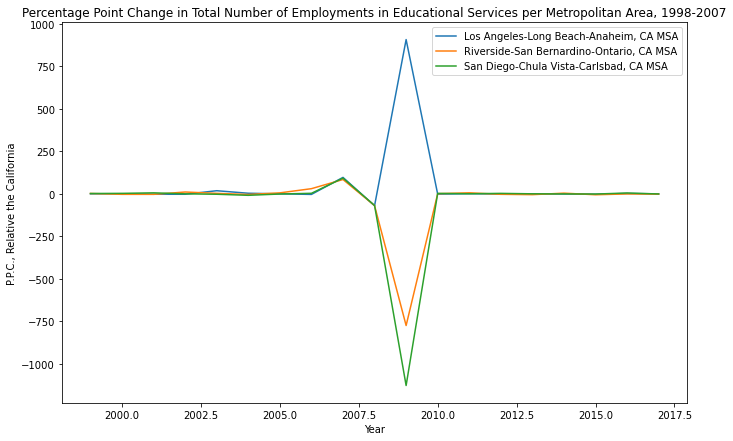

In [255]:
plt.figure()

fsize = 7
plt.gcf().set_size_inches(fsize*1.6,fsize)

NAICS_code = '61'

MSA = 'Los Angeles-Long Beach-Anaheim, CA MSA'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
plt.plot( list(range(year_start+1,2018)),ppc_relative_state ,label= MSA)


MSA = 'Riverside-San Bernardino-Ontario, CA MSA'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
plt.plot( list(range(year_start+1,2018)),ppc_relative_state ,label= MSA)

MSA = 'San Diego-Chula Vista-Carlsbad, CA MSA'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
plt.plot( list(range(year_start+1,2018)),ppc_relative_state ,label= MSA)

plt.xlabel('Year')
plt.ylabel('P.P.C., Relative the California')
plt.title('Percentage Point Change in Total Number of Employments in Educational Services per Metropolitan Area, 1998-2007')
plt.legend()
plt.savefig('data/ppc_totEmp_education.png')

Text(0, 0.5, 'P.P.C., Relative the California')

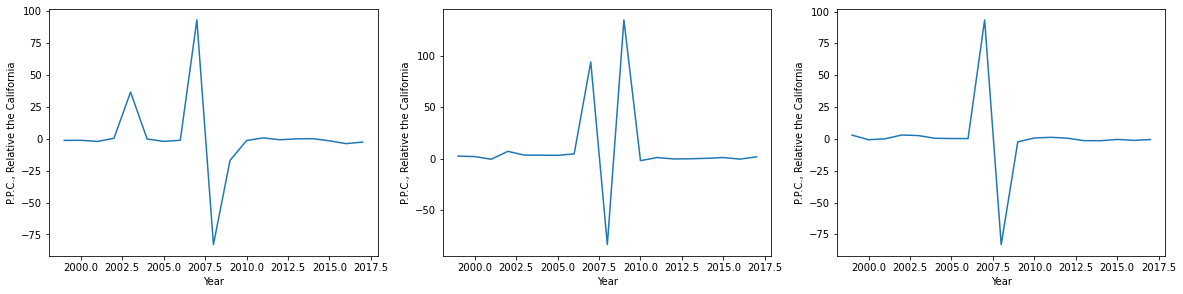

In [239]:
plt.figure()

fsize = 10
plt.gcf().set_size_inches(fsize*2,fsize)

MSA = 'Los Angeles-Long Beach-Anaheim, CA MSA'
NAICS_code = '--'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
#plt.subplot(2,3,(0,0))
plt.subplot(231)
plt.plot( list(range(year_start+1,2018)),ppc_relative_state  )
#plt.plot( relative_state.index,ppc_relative_country  )
plt.xlabel('Year')
plt.ylabel('P.P.C., Relative the California')


MSA = 'Riverside-San Bernardino-Ontario, CA MSA'
NAICS_code = '--'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
#plt.subplot( (2,3,(1,1) ) )
plt.subplot( 232 )
plt.plot( list(range(year_start+1,2018)),ppc_relative_state  )
#plt.plot( relative_state.index,ppc_relative_country  )
plt.xlabel('Year')
plt.ylabel('P.P.C., Relative the California')


NAICS_code = '--'
MSA = 'San Diego-Chula Vista-Carlsbad, CA MSA'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
plt.subplot( 233 )
plt.plot( list(range(year_start+1,2018)),ppc_relative_state  )
#plt.plot( relative_state.index,ppc_relative_country  )
plt.xlabel('Year')
plt.ylabel('P.P.C., Relative the California')


In [ ]:
MSA = 'Riverside-San Bernardino-Ontario, CA MSA'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
plt.subplot( (2,3,(2,1) ) )
plt.plot( list(range(year_start+1,2018)),ppc_relative_state  )
#plt.plot( relative_state.index,ppc_relative_country  )
plt.xlabel('Year')
plt.ylabel('Percentage Point Change, Relative the California')

MSA = 'San Diego-Chula Vista-Carlsbad, CA MSA'
ppc = df_all_ppc[ (MSA,NAICS_code) ]
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
plt.subplot( (2,3,(2,2) ) )
plt.plot( list(range(year_start+1,2018)),ppc_relative_state  )
#plt.plot( relative_state.index,ppc_relative_country  )
plt.xlabel('Year')
plt.ylabel('Percentage Point Change, Relative the California')

<BarContainer object of 19 artists>

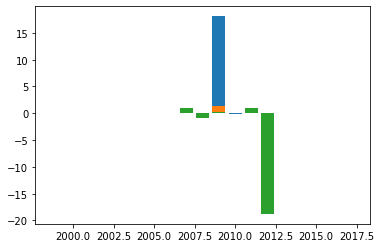

In [160]:
plt.figure()
plt.bar( relative_state.index,ppc  )
plt.bar( relative_state.index,ppc_relative_state  )
plt.bar( relative_state.index,ppc_relative_country  )

In [229]:
df_all

Total Employment - 1998  Total Employment - 1999  \
MSA             NAICS Code                                                     
Abilene, TX MSA --                          48503.0                  48514.0   
                21                           1042.0                    491.0   
                23                           2396.0                   2300.0   
                31-33                        3462.0                   3702.0   
                44-45                        7342.0                   7339.0   
...                                             ...                      ...   
Yuma, AZ MSA    31-33                        3082.0                   2164.0   
                42                           1872.0                   1682.0   
                44-45                        6308.0                   6476.0   
                52                            934.0                    964.0   
                54                            717.0                    745.0   

                            Total Employment - 2000  Total Employment - 2001  \
MSA             NAICS Code                                                     
Abilene, TX MSA --                          49157.0                  48664.0   
                21                            635.0                    693.0   
                23                           2506.0                   2316.0   
                31-33                        3706.0                   3281.0   
                44-45                        7230.0                   7489.0   
...                                             ...                      ...   
Yuma, AZ MSA    31-33                        2321.0                   2317.0   
                42                           1626.0                   1814.0   
                44-45                        6681.0                   7076.0   
                52                            951.0                    970.0   
                54                            804.0                    863.0   

                            Total Employment - 2002  Total Employment - 2003  \
MSA             NAICS Code                                                     
Abilene, TX MSA --                          49969.0                  57108.0   
                21                            834.0                    875.0   
                23                           3002.0                   3670.0   
                31-33                        3177.0                   3487.0   
                44-45                        7633.0                   8472.0   
...                                             ...                      ...   
Yuma, AZ MSA    31-33                        2856.0                   3111.0   
                42                           3686.0                   1880.0   
                44-45                        6558.0                   6675.0   
                52                            859.0                    898.0   
                54                            974.0                   1037.0   

                            Total Employment - 2004  Total Employment - 2005  \
MSA             NAICS Code                                                     
Abilene, TX MSA --                          55427.0                  53961.0   
                21                            931.0                   1038.0   
                23                           2537.0                   2909.0   
                31-33                        2918.0                   2792.0   
                44-45                        8634.0                   8586.0   
...                                             ...                      ...   
Yuma, AZ MSA    31-33                        3398.0                   3621.0   
                42                           1854.0                   1749.0   
                44-45                        7019.0                   8316.0   
                52       

In [178]:
#df_state_all_ppc['California']
df_state_all_ppc['United States']

NAICS Code,--,11,21,22,23,31-33,42,44-45,48-49,51,...,53,54,55,56,61,62,71,72,81,99
1999,0.023936,0.026749,-0.082764,-0.022229,0.069441,-0.016890,0.014747,0.016509,0.047488,0.029442,...,0.033686,0.062795,0.031244,0.076076,0.046433,0.007749,0.035480,0.018100,0.022376,0.476915
2000,0.030345,-0.044703,-0.001132,-0.017737,0.059851,-0.011161,0.023444,0.025154,0.044925,0.096212,...,0.036426,0.059666,0.030573,0.092222,0.041372,0.017572,0.061869,0.025204,0.027552,0.350525
2001,0.008734,-0.000485,0.064537,-0.001139,-0.012294,-0.031782,0.004918,0.003336,-0.010380,0.058935,...,0.036882,0.049934,0.001984,-0.008329,0.031633,0.030199,0.022317,0.009248,0.014562,-0.267214
2002,-0.023123,-0.012612,-0.040757,-0.009519,-0.028439,-0.097603,-0.045886,-0.004727,-0.045232,-0.058215,...,0.001825,-0.015423,0.012008,-0.084172,0.034162,0.025141,0.011587,0.007679,0.009237,-0.688590
2003,0.008874,-0.002699,-0.024100,0.042705,0.011738,-0.018174,0.000615,0.003234,0.135973,0.018037,...,0.013578,0.041730,-0.011889,0.025535,0.027738,0.038391,0.017765,0.038888,-0.009764,0.414508
2004,0.014788,0.008014,0.034606,-0.060958,0.041721,-0.021939,0.007366,0.032527,0.007605,-0.035411,...,0.020221,0.031298,-0.018884,0.023136,0.042041,0.022145,0.030583,0.029710,0.009135,0.186098
2005,0.010794,-0.073451,0.057396,-0.002565,0.020110,-0.011188,0.010475,-0.000831,0.016870,-0.020109,...,0.027799,0.015771,0.011198,0.065713,-0.004829,0.013300,0.025113,0.025684,-0.004660,-0.433355
2006,0.030951,-0.018270,0.114748,-0.029504,0.082207,-0.002609,0.010340,0.027981,0.033203,-0.001867,...,0.033919,0.047433,0.020734,0.077944,0.034778,0.026597,0.019195,0.032226,0.012540,-0.052451
2007,-0.941838,-0.851727,-0.961550,-0.989346,-0.882370,-0.973730,-0.937347,-0.938580,-0.962657,-0.978091,...,-0.899108,-0.913776,-0.998668,-0.967803,-0.973423,-0.943019,-0.945052,-0.945812,-0.836892,-0.932891
2008,-0.127362,-0.062533,-0.092474,-0.095325,-0.061787,-0.407188,-0.153856,-0.209924,0.032075,-0.141826,...,0.488362,0.224372,0.123552,0.000559,-0.240314,-0.374354,-0.115750,-0.463559,-0.110601,-1.000000


In [180]:
df_state_all

Total Employment - 1998  Total Employment - 1999  \
State         NAICS Code                                                     
United States --                      108117731.0              110705661.0   
              11                         187149.0                 192155.0   
              21                         497849.0                 456645.0   
              22                         682227.0                 667062.0   
              23                        5798942.0                6201626.0   
...                                           ...                      ...   
Wyoming       54                           6110.0                   6214.0   
              55                           1200.0                   1222.0   
              56                           4684.0                   5666.0   
              62                          23694.0                  24481.0   
              72                          22882.0                  23435.0   

                          Total Employment - 2000  Total Employment - 2001  \
State         NAICS Code                                                     
United States --                      114064976.0              115061184.0   
              11                         183565.0                 183476.0   
              21                         456128.0                 485565.0   
              22                         655230.0                 654484.0   
              23                        6572800.0                6491994.0   
...                                           ...                      ...   
Wyoming       54                           6313.0                   6577.0   
              55                           1356.0                   1147.0   
              56                           5735.0                   6295.0   
              62                          25398.0                  25615.0   
              72                          24242.0                  24517.0   

                          Total Employment - 2002  Total Employment - 2003  \
State         NAICS Code                                                     
United States --                      112400654.0              113398043.0   
              11                         181162.0                 180673.0   
              21                         465775.0                 454550.0   
              22                         648254.0                 675938.0   
              23                        6307370.0                6381404.0   
...                                           ...                      ...   
Wyoming       54                           6917.0                   7223.0   
              55                           1176.0                    892.0   
              56                           5777.0                   6289.0   
              62                          26535.0                  27127.0   
              72                          23693.0                  24686.0   

                          Total Employment - 2004  Total Employment - 2005  \
State         NAICS Code                                                     
United States --                      115074924.0              116317003.0   
              11                         182121.0                 168744.0   
              21                         470280.0                 497272.0   
              22                         634734.0                 633106.0   
              23                        6647641.0                6781327.0   
...                                           ...                      ...   
Wyoming       54                           7605.0                   7951.0   
              55                            756.0                    752.0   
              56                           6587.0                   6626.0   
              62                          27645.0                  28269.0   
              72                          249

In [156]:
MSA_to_state_dict

{'New York City-Newark-Jersey City, NY-NJ-PA MSA': 'NY-NJ-PA',
 'Los Angeles-Long Beach-Anaheim, CA MSA': 'CA',
 'Chicago-Naperville-Elgin, IL-IN-WI MSA': 'IL-IN-WI',
 'Dallas-Fort Worth-Arlington, TX MSA': 'TX',
 'Houston-The Woodlands-Sugar Land, TX MSA': 'TX',
 'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA': 'DC-VA-MD-WV',
 'Miami-Fort Lauderdale-West Palm Beach, FL MSA': 'FL',
 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA': 'PA-NJ-DE-MD',
 'Atlanta-Sandy Springs-Alpharetta, GA MSA': 'GA',
 'Phoenix-Mesa-Chandler, AZ MSA': 'AZ',
 'Boston-Cambridge-Newton, MA-NH MSA': 'MA-NH',
 'San Francisco-Oakland-Berkeley, CA MSA': 'CA',
 'Riverside-San Bernardino-Ontario, CA MSA': 'CA',
 'Detroit–Warren–Dearborn, MI MSA': 'MI',
 'Seattle-Tacoma-Bellevue, WA MSA': 'WA',
 'Minneapolis-St. Paul-Bloomington, MN-WI MSA': 'MN-WI',
 'San Diego-Chula Vista-Carlsbad, CA MSA': 'CA',
 'Tampa-St. Petersburg-Clearwater, FL MSA': 'FL',
 'Denver-Aurora-Lakewood, CO MSA': 'CO',
 'St. Louis, MO-IL MSA': 

In [135]:
#SA_to_state_dict
abbr_to_state_dict

{'AL': 'Alabama ',
 'AK': 'Alaska ',
 'AS': 'American Samoa ',
 'AZ': 'Arizona ',
 'AR': 'Arkansas ',
 'CA': 'California ',
 'CO': 'Colorado ',
 'CT': 'Connecticut ',
 'DE': 'Delaware ',
 'DC': 'District Of Columbia ',
 'FL': 'Florida ',
 'GA': 'Georgia ',
 'GU': 'Guam ',
 'HI': 'Hawaii ',
 'ID': 'Idaho ',
 'IL': 'Illinois ',
 'IN': 'Indiana ',
 'IA': 'Iowa ',
 'KS': 'Kansas ',
 'KY': 'Kentucky ',
 'LA': 'Louisiana ',
 'ME': 'Maine ',
 'MD': 'Maryland ',
 'MA': 'Massachusetts ',
 'MI': 'Michigan ',
 'MN': 'Minnesota ',
 'MS': 'Mississippi ',
 'MO': 'Missouri ',
 'MT': 'Montana ',
 'NE': 'Nebraska ',
 'NV': 'Nevada ',
 'NH': 'New Hampshire ',
 'NJ': 'New Jersey ',
 'NM': 'New Mexico ',
 'NY': 'New York ',
 'NC': 'North Carolina ',
 'ND': 'North Dakota ',
 'MP': 'Northern Mariana Is ',
 'OH': 'Ohio ',
 'OK': 'Oklahoma ',
 'OR': 'Oregon ',
 'PA': 'Pennsylvania ',
 'PR': 'Puerto Rico ',
 'RI': 'Rhode Island ',
 'SC': 'South Carolina ',
 'SD': 'South Dakota ',
 'TN': 'Tennessee ',
 'TX': 'T